In [1]:
import pandas as pd
import mxnet as mx
import random
from mxnet import nd, gluon, init, autograd
from mxnet.gluon import nn
import time
import matplotlib.pyplot as plt

In [2]:
data = '../data/Left1.csv'

In [3]:
df = pd.read_csv(data, index_col = 0)

In [4]:
df.head()

,Source,Serial,City,Station,Latitude,Longitude,Datetime,PM,USAQI,CO2,Temperature,RelativeHumidity,weekday,hour,month,year,dayofmonth
0,EPD,NaN,Lahore,Quaid-e-azam Township,NaN,NaN,2014-07-31 00:00:00,94.335,NaN,NaN,NaN,NaN,3,0,7,2014,31
1,EPD,NaN,Lahore,Town Hall,NaN,NaN,2014-07-31 00:00:00,93.620,NaN,NaN,NaN,NaN,3,0,7,2014,31
2,EPD,NaN,Lahore,Town Hall,NaN,NaN,2014-08-31 00:00:00,57.700,NaN,NaN,NaN,NaN,6,0,8,2014,31
3,EPD,NaN,Lahore,Quaid-e-azam Township,NaN,NaN,2014-09-30 00:00:00,151.000,NaN,NaN,NaN,NaN,1,0,9,2014,30
4,EPD,NaN,Lahore,Town Hall,NaN,NaN,2014-09-30 00:00:00,49.540,NaN,NaN,NaN,NaN,1,0,9,2014,30


In [5]:
df_new = df.drop(['Source', 'Serial', 'Station', 'Latitude', 'Longitude', 'Datetime'], axis = 1)

In [6]:
print(df_new.isna().mean())
print(len(df_new))
print(df_new.City.unique())

df_ready = df_new.dropna()
print(len(df_ready))
print(df_ready.City.unique())

City                0.000000
PM                  0.000000
USAQI               0.003970
CO2                 0.521804
Temperature         0.123743
RelativeHumidity    0.123623
weekday             0.000000
hour                0.000000
month               0.000000
year                0.000000
dayofmonth          0.000000
dtype: float64
391917
['Lahore' 'Karachi' 'Islamabad' 'Peshawar' 'Chakwal' 'Faisalabad'
 'Gujranwala' 'Bahawalpur' 'Rawalpindi' 'Muridke' 'Raiwind' 'Diplo'
 'Sialkot']
187340
['Karachi' 'Islamabad' 'Lahore' 'Peshawar' 'Bahawalpur' 'Diplo']


In [7]:
df_ready.head()

,City,PM,USAQI,CO2,Temperature,RelativeHumidity,weekday,hour,month,year,dayofmonth
14,Karachi,24.0,76.0,502.0,30.0,78.0,3,14,10,2016,6
15,Karachi,22.0,72.0,420.0,30.0,76.0,3,15,10,2016,6
16,Karachi,21.0,70.0,416.0,30.0,76.0,3,17,10,2016,6
17,Karachi,22.0,72.0,416.0,28.0,80.0,3,18,10,2016,6
18,Karachi,23.0,74.0,415.0,28.0,80.0,3,19,10,2016,6


In [8]:
def transform(df):
    df = (df - df.mean())/df.std()
    return df

In [9]:
def createDataSets(df, city, frac):
    
    df_part = df[df.City != city]
    indexes = list(df_part.index)
    random.shuffle(indexes)
    length = int(len(indexes) * frac)
    take = indexes[:length]
    
    df = df.drop('City', axis = 1)
    df = transform(df)
    
    df_train = df.loc[take]
    df_test = df.drop(take)
    return df_train, df_test
    


In [10]:
def createXandY(df):
    Y = df['CO2']
    X = df.drop(['CO2'], axis = 1)
    return nd.array(X.values), nd.array(Y.values)

In [11]:
means = df_ready.drop('City' , axis = 1).mean()
stds = df_ready.drop('City' , axis = 1).std()

df_train, df_test = createDataSets(df_ready, 'Islamabad', 0.7)
X_train, Y_train = createXandY(df_train)
X_test, Y_test = createXandY(df_test)

print(len(X_test)/ (len(X_test) + len(X_train)))

0.34038112522686026


In [12]:
net = nn.Sequential()

In [13]:
net.add(nn.Dense(3, activation = 'sigmoid'),
        nn.Dense(1, activation = 'sigmoid'),
       )

In [14]:
net.initialize(init = init.Xavier(), force_reinit = True)

In [15]:
loss = gluon.loss.L2Loss()
lr = 0.005
batch_size = 256

trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})

In [16]:
epochs = 10
train_iter = mx.io.NDArrayIter(X_train, Y_train, batch_size, shuffle = True)

train_losses = []
test_losses = []

for epoch in range(epochs):
    for trn_batch in train_iter:
        x = trn_batch.data[0]
        y = trn_batch.label[0]
        
        with mx.autograd.record():
            y_pred = net(x)
            im_loss = loss( y_pred, y)
        
        #backprop
        im_loss.backward()
        
        #Optimize!
        trainer.step(batch_size=batch_size)
        
    train_iter.reset()
    print('epoch ', epoch)
    out = net(X_test)
    ls1 = loss(out, Y_test).mean().asscalar()
    ls2 = loss(net(X_train), Y_train).mean().asscalar()
    train_losses.append(ls2)
    test_losses.append(ls1)
    print('test\t', ls1, '\ttrain\t', ls2)
    

epoch  0
test	 0.8065801 	train	 0.32157344
epoch  1
test	 0.80786586 	train	 0.3168026
epoch  2
test	 0.80807894 	train	 0.31464982
epoch  3
test	 0.80677927 	train	 0.31338862
epoch  4
test	 0.8072275 	train	 0.31237197
epoch  5
test	 0.8081944 	train	 0.3117352
epoch  6
test	 0.8070549 	train	 0.31100276
epoch  7
test	 0.8068978 	train	 0.3105162
epoch  8
test	 0.80605865 	train	 0.3101296
epoch  9
test	 0.806435 	train	 0.30979094


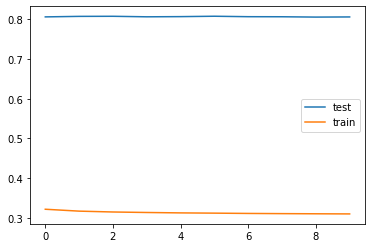

In [17]:
plt.plot(test_losses, label = 'test')
plt.plot(train_losses, label = 'train')
plt.legend()
plt.show()